# Part 2

### ALWAYS run this code below first 

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

# Helper functions
def is_integer(x):
   
    try:
        return (int(x) == float(x))
    except:
        return False

def ingest_files(directory: str):
    
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print(" Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)
        
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = (output[i].id.apply( lambda x : is_integer(x) == False ))
        if invalid_rows.sum() > 0:
            print(" Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][invalid_rows == False]
    
    return output

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

def visualize_columns(data, float_cols, cat_cols, date_cols):
    '''
    This function visualizes all columns
      - Box-and-whisker plots for continuous variables
      - Lists of distinct values for categorical columns
      - A timeline density for dates
    '''
    
    # FLoat columns
    for i in float_cols:
        seaborn.boxplot(data[i])

        # Print the three highest values
        highest_vals = sorted(data[i], reverse=True)[:3]
        smallest_val = min(data[i])
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(data[i]))) + " distinct values")
        print(data[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        data[data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(data[i].isnull().sum()) + " null values)")
        plt.show()

# Identify the columns we'll be keeping from the dataset
cols_to_pick = ["id",
                "loan_amnt",
                "funded_amnt",
                "revol_util",
                "revol_bal",
                "fico_range_low",
                "fico_range_high",
                "pub_rec",
                "open_acc",
                "earliest_cr_line",
                "delinq_2yrs",
                "dti",
                "purpose",
                "issue_d",
                "annual_inc",
                "home_ownership",
                "emp_length",
                "grade",
                "term",
                "int_rate",
                "installment",
                "verification_status",
                "recoveries",
                "loan_status",
                "last_pymnt_d",
                "total_pymnt"]

# Identify the type of each of these column

float_cols = ["loan_amnt",
                "funded_amnt",
                "revol_bal",
                "fico_range_low",
                "fico_range_high",
                "pub_rec",
                "open_acc",
                "delinq_2yrs",
                "dti",
                "annual_inc",
                "installment",
                "recoveries",
                "total_pymnt"]

cat_cols = ["purpose",
            "home_ownership",
            "emp_length",
            "grade",
            "term",
            "verification_status",
            "loan_status"]

perc_cols = ["revol_util",
             "int_rate"]

date_cols = ["earliest_cr_line",
             "issue_d",
             "last_pymnt_d"]


# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

# Define the names of the four returns we'll be calculating
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc"]

# Some of the columns selected will not be used directly in the model, but will be used to generate other features.
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features
discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

# Question 1

In [2]:
# Read in data
print ("Reading in data...")

# Define the directories that contain the full dataset files downloaded in 2019
dir_full = "/".join(["Data"] + ["full_dataset"] )

# Ingest the set of files
files_full = ingest_files(dir_full)
data_all = pd.concat(files_full.values()).reset_index(drop = True)

# Keep only the columns we care about
final_data = data_all[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

Reading in data...
Directory Data/full_dataset/ has 15 files:
 Reading file LoanStats_securev1_2018Q4.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2019Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2019Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2019Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q4.csv
 Found 2 invalid rows which were removed
 Re

In [7]:
new_data = data_all[['total_pymnt', 'total_pymnt_inv']].copy()
new_data.head()


,total_pymnt,total_pymnt_inv
0,7481.0,7481.00
1,26653.1675796436,26653.17
2,5777.82,5777.82
3,3491.95,3491.95
4,36266.741551619,36266.74


# Question 2

In [ ]:
# Read in data
print ("Reading in data...")

# Tell where the directories that contain the files downloaded in 2017 and 2019
dir_2017 = "/".join(["Data"] + ["1712_download"] )
dir_2019 = "/".join(["Data"] + ["1912_download"] )

# Ingest the set of files downloaded in 2017 and then the files downloaded in 2019
files_2017 = ingest_files(dir_2017)
files_2019 = ingest_files(dir_2019)

In [23]:
# Check the two sets of files have the same number of files
# with the same names
assert len(files_2017) == len(files_2019)
assert sorted(files_2017) == sorted(files_2019)

# Ensure each set of files has the same loan IDs in both instances
for i in files_2017:
    assert sorted(files_2017[i].id) == sorted(files_2019[i].id)
    

data_2017 = pd.concat(files_2017.values()).reset_index(drop = True)
data_2019 = pd.concat(files_2019.values()).reset_index(drop = True)

print("Loading complete, let's compare columns...")
print(set(data_2017.columns) - set(data_2019.columns))

print("Looks like disbursement_method is not found on 2019 data, we will remove this column.")

# There is somethings that not quite right
# 2017 dataset has an additional column which is disbursement_method
data_2017.drop(['disbursement_method'], axis=1, inplace=True)

print("Now we will merge the two datasets to compare...")

# Ensure the loan IDs are a unique key
assert len(set(data_2019.id)) == len(data_2019)
assert len(set(data_2017.id)) == len(data_2017)

# Ensure columns are same
columns = list(data_2017.columns)
assert sorted(columns) == sorted(data_2019.columns)

# Just in case, check the datasets have the same number of rows
n_rows = len(data_2017)
assert n_rows == len(data_2019)

# Merge them
combined = pd.merge(data_2017, data_2019, how = 'inner', on="id", suffixes=('_x', '_y'))

# Ensure the merged dataset has the same number of rows
assert n_rows == len(combined)

print("Let's look for static columns...")

# Go through each column, and find what percentage of the values in
# that column are identical in the two datasets
static_perc = {}

# Remove the ID column first
columns = [i for i in columns if i != "id"]

for i in columns:
    combined[i+"_comp"] = (combined[i+"_x"] == combined[i+"_y"]) | (combined[i+"_x"].isnull() & combined[i+"_y"].isnull())
    static_perc[i] = combined[i+"_comp"].sum()*100.0/len(combined)
    
static_perc_data = pd.DataFrame([ [i, static_perc[i]] for i in static_perc], columns=["column", "perc_equal"]).\
                                                    sort_values("perc_equal", ascending = False)

# Ensure that the columns we want to pick for our model are in
# the above, and check how consistent they've been
assert set(cols_to_pick) - set(static_perc_data.column) - set(["id"]) == set()

print("Below is the percentange of data for each of our columns that is the same:")

print(static_perc_data[static_perc_data.column.isin(cols_to_pick)])


Directory Data/1712_download/ has 8 files:
 Reading file LoanStats_securev1_2017Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q4.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q4.csv
 Found 2 invalid rows which were removed
Directory Data/1912_download/ has 8 files:
 Reading file LoanStats_securev1_2017Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q3.csv
 Found 2 invalid row

In [24]:
# There are 35 rows where the int_rate_comp and installment_comp values do not have same comparison
(combined["int_rate_comp"] != combined["installment_comp"]).sum()

# what do you notice looking at these loans?
combined.loc[(combined["int_rate_comp"] != combined["installment_comp"]),:].loc[:,['id','int_rate_x','int_rate_y','term_x','term_y','installment_x','installment_y']]

,id,int_rate_x,int_rate_y,term_x,term_y,installment_x,installment_y
39423,99535008,6.00%,6.00%,60 months,60 months,691.94,683.53
104473,111428146,6.00%,6.00%,36 months,36 months,304.18,298.27
128866,109651663,13.59%,13.59%,36 months,36 months,203.88,199.55
135919,110022313,20.00%,20.00%,36 months,36 months,628.07,595.85
152502,108147170,6.00%,6.00%,36 months,36 months,122.78,122.7
159709,107600128,12.74%,12.74%,60 months,60 months,361.93,348.79
174039,106508810,18.99%,18.99%,36 months,36 months,73.31,67.06
203968,120018914,7.35%,7.35%,36 months,36 months,1241.5,1235
244907,117273468,12.62%,12.62%,36 months,36 months,33.52,32.04
278811,114853903,6.00%,6.00%,36 months,36 months,591.71,573.14


# Question 3

In [3]:
# Read in data
print ("Reading in data...")

# Define the directories that contain the full dataset files downloaded in 2019
dir_full = "/".join(["Data"] + ["full_dataset"] )

# Ingest the set of files
files_full = ingest_files(dir_full)
data_all = pd.concat(files_full.values()).reset_index(drop = True)

# Keep only the columns we care about
final_data = data_all[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

Reading in data...
Directory Data/full_dataset/ has 15 files:
 Reading file LoanStats_securev1_2018Q4.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2019Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2019Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2019Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q4.csv
 Found 2 invalid rows which were removed
 Re

In [4]:
print("Starting with " + str(len(final_data)) + " rows")
print("Casting column types...")
for i in float_cols:
    final_data[i] = final_data[i].astype(float)
    
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )

for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )
    
for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None
    
print("Removing null columns...")
required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

print("Removing unfinished loans...")
# select only terminated loans
final_data = final_data[final_data.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(final_data)) + " rows")

# Only include loans isssued since 2011
print("Removing loans older than 2011...")
n_rows = len(final_data)
final_data = final_data[final_data.issue_d >= datetime.date(2011, 1, 1)]
print("Removed " + str(n_rows - len(final_data)) + " rows")


print("Ending with " + str(len(final_data)) + " rows")

print("Saving pickle file...")
# Define the output path for the pickle
pickle_file = "/".join(["Data"] + ["clean_data.pickle"] )

pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )
print("Saved to Data/clean_data.pickle")

Casting column types...
Removing null columns...
Removed 6794 rows
Removing unfinished loans...
Removed 975384 rows
Removing loans newer than 2011...
Removed 0 rows
Ending with 787693 rows
Saving pickle file...


# Question 4

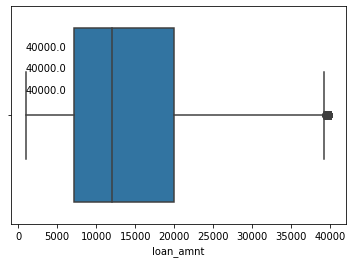

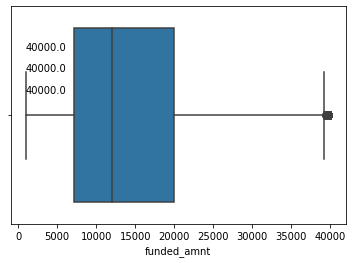

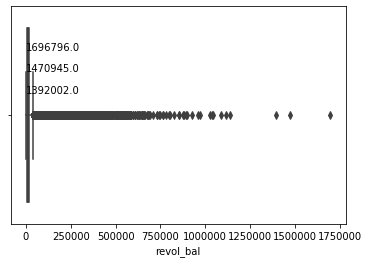

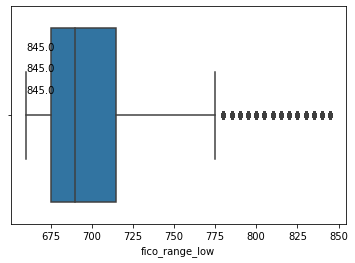

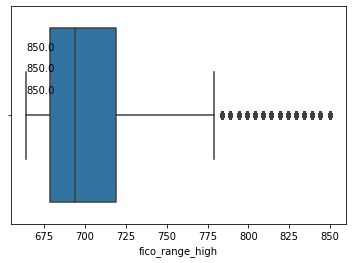

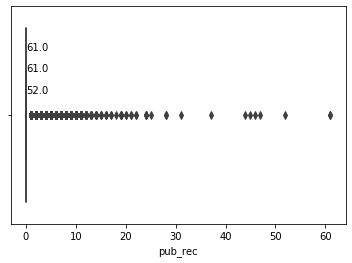

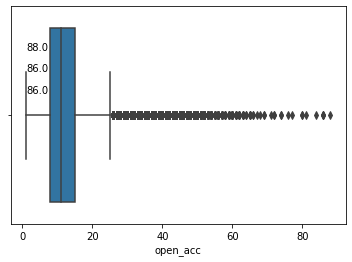

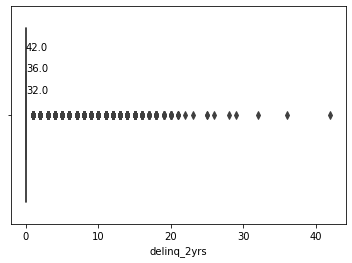

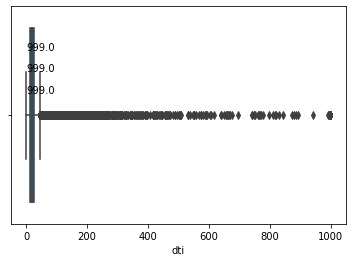

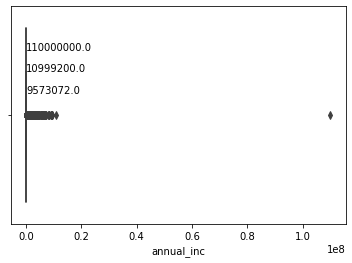

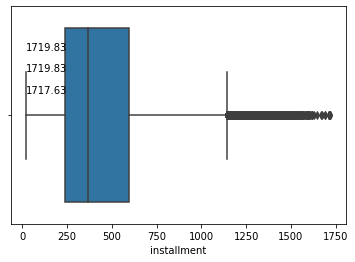

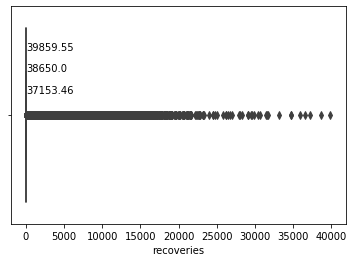

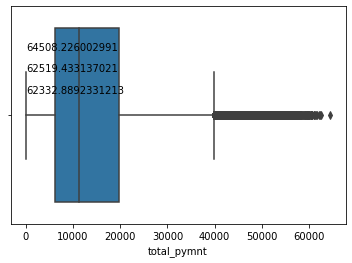

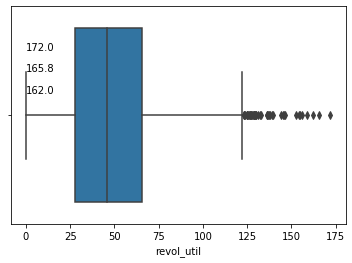

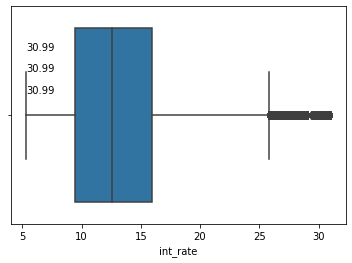

purpose
14 distinct values
debt_consolidation    440696
credit_card           163934
home_improvement       58666
other                  56638
major_purchase         19758
medical                11125
car                     9180
small_business          8306
vacation                6772
moving                  6273
house                   5781
renewable_energy         557
wedding                    6
educational                1
Name: purpose, dtype: int64


home_ownership
5 distinct values
MORTGAGE    386784
RENT        304481
OWN          95732
ANY            692
NONE             4
Name: home_ownership, dtype: int64


emp_length
12 distinct values
10+ years    262277
2 years       72475
< 1 year      65250
3 years       63952
1 year        53068
5 years       48463
4 years       48005
6 years       34140
8 years       29213
9 years       27409
7 years       27139
Name: emp_length, dtype: int64


grade
7 distinct values
B    234953
C    232657
A    148542
D    110686
E     42237
F    

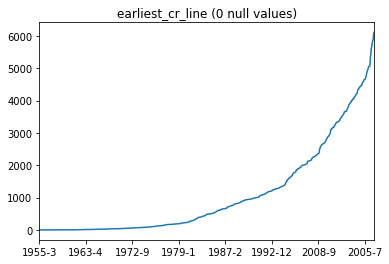

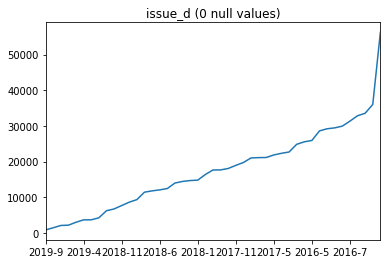

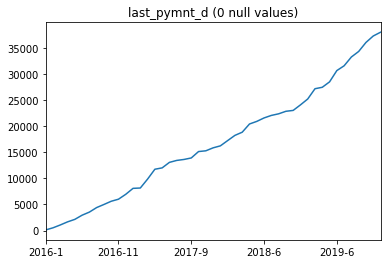

In [5]:
# Visualize the data
visualize_columns(final_data, float_cols + perc_cols, cat_cols, date_cols)

Removed 7 rows


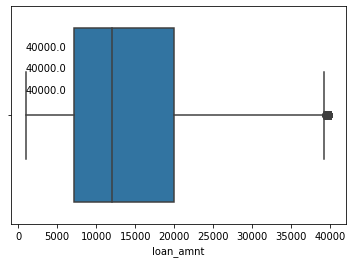

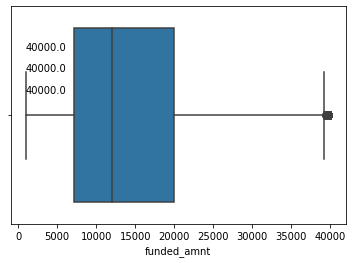

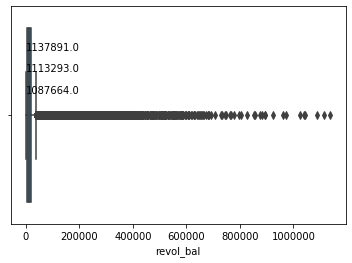

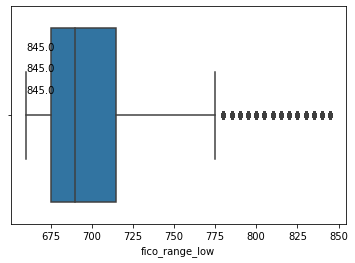

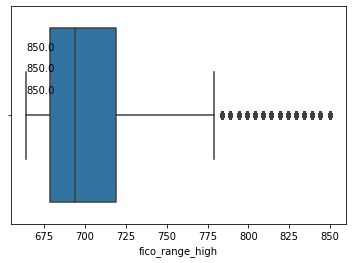

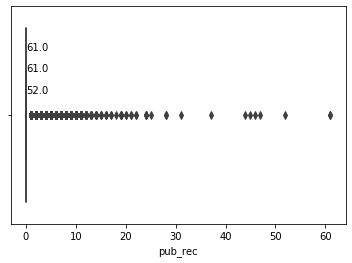

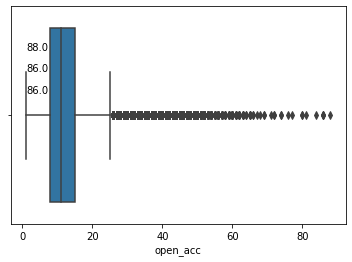

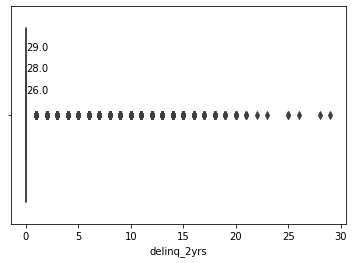

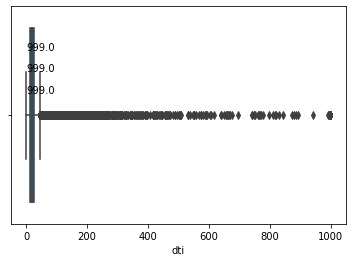

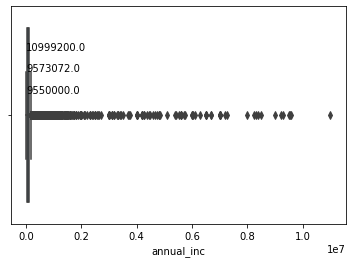

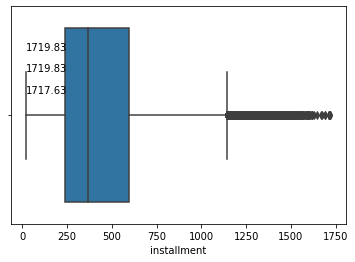

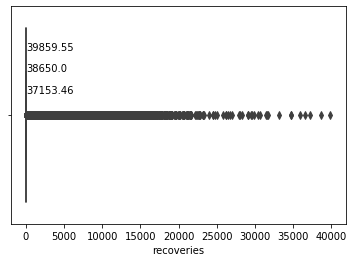

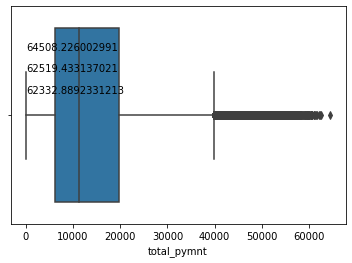

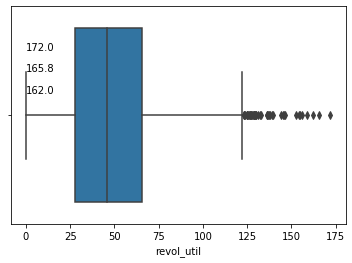

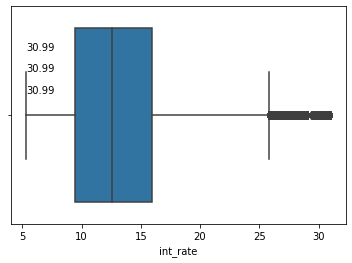

purpose
14 distinct values
debt_consolidation    440695
credit_card           163931
home_improvement       58664
other                  56638
major_purchase         19758
medical                11125
car                     9180
small_business          8305
vacation                6772
moving                  6273
house                   5781
renewable_energy         557
wedding                    6
educational                1
Name: purpose, dtype: int64


home_ownership
5 distinct values
MORTGAGE    386779
RENT        304479
OWN          95732
ANY            692
NONE             4
Name: home_ownership, dtype: int64


emp_length
12 distinct values
10+ years    262273
2 years       72475
< 1 year      65250
3 years       63951
1 year        53068
5 years       48463
4 years       48005
6 years       34140
8 years       29213
9 years       27409
7 years       27139
Name: emp_length, dtype: int64


grade
7 distinct values
B    234951
C    232656
A    148541
D    110685
E     42235
F    

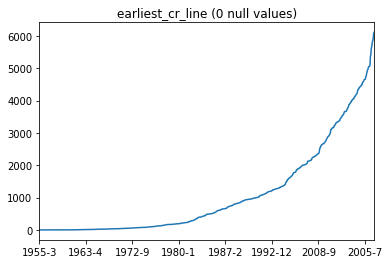

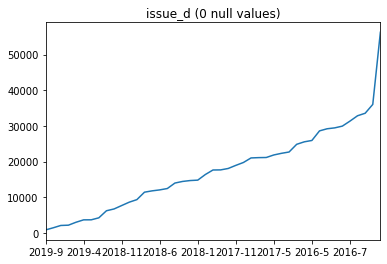

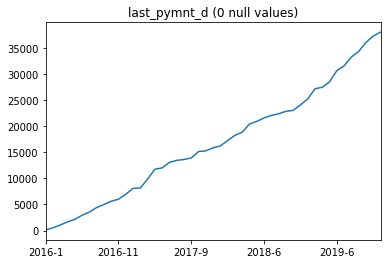

In [6]:
# Remove outliers and then vizualize the data again
n_rows = len(final_data)
final_data = final_data[final_data.annual_inc < 100000000]
final_data = final_data[final_data.revol_bal < 1250000]
final_data = final_data[final_data.delinq_2yrs < 32]
print("Removed " + str(n_rows - len(final_data)) + " rows")

# Visualize the data
visualize_columns(final_data, float_cols + perc_cols, cat_cols, date_cols)